## CDAE af time series

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import h5py as h5
import keras
import sklearn
import matplotlib.pyplot as plt
# import datashader as ds
# import datashader.transfer_functions as ds_tf
import IPython
import holoviews as hv
import random
hv.extension('bokeh')

from bokeh.io import output_file, save, show
from holoviews import opts
# from holoviews.operation.datashader import datashade, dynspread

from IPython.display import display

import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings("ignore")
import sys
#import os

from sklearn.multioutput import MultiOutputClassifier
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, average_precision_score, precision_recall_curve, accuracy_score, confusion_matrix  
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split

import pickle

print("Python version:\n{}\n".format(sys.version))
# print("matplotlib version: {}".format(plt.__version__))
print("pandas version: {}".format(pd.__version__))
print("numpy version: {}".format(np.__version__))
print("sklearn version: {}".format(sklearn.__version__))
print("keras version: {}".format(keras.__version__))

Output hidden; open in https://colab.research.google.com to view.

In [3]:
# load and format raw data
def load_ppg(data):
    signal_data = data['signal']
    # squeeze out extra dimension padding
    signal_data = np.squeeze(signal_data, axis=-1)
    print(len(signal_data[0]))
    
    return signal_data;

# modulate noise per signal via sliding window 
def modulate_noise(noise, window=4):
    noise_toret = np.zeros(noise.shape[0], dtype=float)
    idx = 0
    while (idx < noise.shape[0]):
        rand = random.randint(0, 100)
        if(rand >= 60):
            noise_toret[idx:idx+window] = noise.squeeze()[idx:idx+window]
            idx+=window
        else:
            idx+=window
        
    return noise_toret

def gen_noise(signal_data, num_signals=1):
    # Set a target SNR
    noises = []
    for idx in range(0,num_signals):
        target_snr_db = 24
        
        raw_mean = np.mean(signal_data[idx, :])
        if raw_mean==0: print('broken noise gen')
        
        sig_avg_db = 10 * np.log10(raw_mean)
        
        # Calculate noise according to [2] then convert to watts
        noise_avg_db = sig_avg_db - target_snr_db
        noise_avg_ppg = 10 ** (noise_avg_db / 10)

        noise_snr = np.random.normal(0, np.sqrt(noise_avg_ppg), 800)
        noises.append(noise_snr)
        
    return np.asarray(noises)

def graph(signals, web_page='graph.html'):
    # # output_signals = (all_sigs).opts(title='test_signals: {}'.format(10))
    # # (datashade(output_signals)).options(width=1000, axiswise=True)
    signals.opts(
    opts.Curve( height=600, width=1000, tools=['hover']),
    )

    display(signals)
    
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

## load data

In [4]:
data = np.load('/content/drive/MyDrive/Colab Notebooks/cdae.npz', allow_pickle=True)
lst = data.files
print(lst)
# Data features: signal, qa_label, rhythm (AF/non-af Label?), parameters
# load data
# signal_data = load_ppg(data)
# qa_labels = data['qa_label']
# af_labels = data['rhythm']
signal_data = data['ppg']
qa_labels = data['qa_labels']
af_labels = data['af_labels']

# params_df = pd.DataFrame(data['parameters'])
# params_df.rename(columns = {0: 'ts',
#                             1: 'stream',
#                             2: 'ID'}, inplace=True)
# params_df.reset_index()
# params_df.groupby(['stream', 'ID']).head()

['ppg', 'af_labels', 'qa_labels']


In [ ]:
print('signals shape', signal_data.shape)
# params_df.nunique()

signals shape (1400000, 800)


## isolate good signals
and modulate these good signals w/ noise

In [5]:
actual_qa_labels = np.argmax(qa_labels, axis=1)

poor_idx = np.where(actual_qa_labels==0)[0]
avg_idx = np.where(actual_qa_labels==1)[0]
good_idx = np.where(actual_qa_labels==2)[0]

good_signals = signal_data[good_idx,: ]
good_signals.shape

(354959, 800)

visualize good signals

In [ ]:
good_af_labels_raw = af_labels[good_idx,: ]
good_af_labels = np.argmax(good_af_labels_raw, axis=1)

af_idx = np.where(good_af_labels==1)[0]
af_idx


array([   0,   11,   18,   21,   25,   26,   27,   32,   34,   42,   45,
         53,   57,   65,   69,   71,   77,   81,   89,   99,  107,  117,
        119,  142,  143,  146,  157,  168,  171,  176,  177,  183,  193,
        195,  201,  202,  210,  239,  242,  255,  261,  284,  286,  291,
        292,  293,  302,  306,  311,  313,  327,  332,  338,  340,  344,
        354,  364,  374,  381,  388,  401,  407,  409,  411,  420,  426,
        431,  432,  455,  457,  460,  465,  486,  503,  510,  518,  531,
        540,  545,  560,  563,  569,  573,  581,  584,  592,  595,  598,
        601,  604,  611,  617,  626,  642,  650,  675,  683,  688,  697,
        699,  700,  708,  712,  738,  745,  747,  751,  767,  771,  789,
        790,  795,  797,  802,  811,  817,  822,  826,  832,  834,  845,
        847,  871,  880,  894,  906,  918,  922,  951,  957,  970,  975,
        984,  993,  999, 1010, 1012, 1016, 1019, 1022, 1025, 1035, 1041,
       1045, 1067, 1070, 1074, 1076, 1087, 1097, 11

In [ ]:
print(good_af_labels.shape)

(1617,)


## generate and modulate noise to match signal data

#### examples of modulating noise:
So instead of noise 100% of the time, simulating noise only occurring for 60% of the signal (so quite noisy).

(1, 800)
(800,)


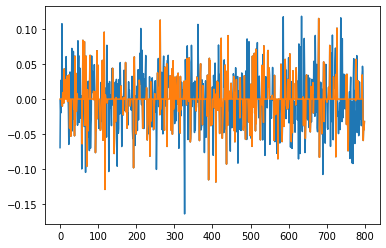

In [6]:
test_noise = gen_noise(good_signals[0:1], num_signals=1)
# graph(hv.Curve(test_noise[0], label='noise'))
print(test_noise.shape)
mod_snr = modulate_noise(test_noise.squeeze(), window=2)
print(mod_snr.shape)

plt.plot(test_noise[0])
plt.plot(mod_snr)


In [ ]:
test_full_noise = good_signals[0]+mod_snr[0]
test_noise_graph = hv.Curve(good_signals[0], label='sig') * hv.Curve(test_noise[0], label='noise') * hv.Curve(mod_snr, label='modulated_noise')
graph(test_noise_graph)

:Overlay
   .Curve.Sig             :Curve   [x]   (y)
   .Curve.Noise           :Curve   [x]   (y)
   .Curve.Modulated_noise :Curve   [x]   (y)

### actually generate noise
generate for all good_signals dataset

In [7]:
# noise_snr = gen_noise(signal_data, num_signals=len(signal_data))
noise_snr = gen_noise(good_signals, num_signals=len(good_signals))
print(noise_snr.shape)

(354959, 800)


modulating all the noise w/ random variable on gausian distribution

In [8]:
modulated_snr = []
# FAT BUG noise_snr, not good_signals loop!!
for curr_noise in noise_snr:
    modulated = modulate_noise(curr_noise, window=2)
    modulated_snr.append(modulated)
    
modulated_snr = np.asarray(modulated_snr)
modulated_snr.shape

(354959, 800)

### create noisy signal dataset
combine modulated noise with ground signals

In [9]:
from sklearn.model_selection import train_test_split

noisy_signal_data = good_signals + modulated_snr
# noisy_signal_data = good_signals + noise_snr

x_train_noisy, x_test_noisy, y_train, y_test = train_test_split(noisy_signal_data, good_signals, test_size=0.2, random_state=42)
# x_train_noisy, x_test_noisy, y_train_af, y_test_af = train_test_split(noisy_signal_data, good_af_labels, test_size=0.2, random_state=42)

In [10]:
x_train_noisy = np.expand_dims(x_train_noisy, axis=2)
x_test_noisy = np.expand_dims(x_test_noisy, axis=2)
y_train = np.expand_dims(y_train, axis=2)
y_test = np.expand_dims(y_test, axis=2)

In [11]:
# y_train = np.expand_dims(y_test, axis=2)
x_train_noisy.shape

(283967, 800, 1)

loading/saving noisy-clean CDAE data

In [12]:
np.savez('/content/drive/MyDrive/Colab Notebooks/CDAE_x_train_noisy.npz', x_train_noisy=x_train_noisy)
np.savez('/content/drive/MyDrive/Colab Notebooks/CDAE_x_test_noisy.npz', x_test_noisy=x_test_noisy)
np.savez('/content/drive/MyDrive/Colab Notebooks/CDAE_y_train.npz', y_train=y_train)
np.savez('/content/drive/MyDrive/Colab Notebooks/CDAE_y_test.npz', y_test=y_test)

# x_train_noisy = np.load('/content/drive/MyDrive/Colab Notebooks/CDAE_x_train_noisy.npz', allow_pickle=True)
# x_test_noisy = np.load('/content/drive/MyDrive/Colab Notebooks/CDAE_x_test_noisy.npz', allow_pickle=True)
# y_train = np.load('/content/drive/MyDrive/Colab Notebooks/CDAE_y_train.npz', allow_pickle=True)
# y_test = np.load('/content/drive/MyDrive/Colab Notebooks/CDAE_y_test.npz', allow_pickle=True)


## design of cdae

#### implementation of conv1dtranspose()

In [13]:
import keras
from keras.models import Model
from tensorflow.keras import backend as K

def Conv1DTranspose(input_tensor, filters, kernel_size, strides=1, activation=None, padding='same'):
    """
        input_tensor: tensor, with the shape (batch_size, time_steps, dims)
        filters: int, output dimension, i.e. the output tensor will have the shape of (batch_size, time_steps, filters)
        kernel_size: int, size of the convolution kernel
        strides: int, convolution step size
        padding: 'same' | 'valid'
    """
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
    x = Conv2DTranspose(filters=filters, kernel_size=(kernel_size, 1), strides=(strides, 1), activation=activation, padding=padding)(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    return x

# class Conv1DTranspose(keras.layers.Layer):
#     def __init__(self, filters=16, kernel_size=3, strides=1, activation='relu', padding='valid'):
#         super().__init__()
#         self.conv2dtranspose = keras.layers.Conv2DTranspose(
#           filters, (kernel_size, 1), (strides, 1), activation, padding
#         )

#     def call(self, x):
#         x = np.expand_dims(x, axis=2)
#         x = self.conv2dtranspose(x)
#         x = np.squeeze(x, axis=2)
#         return x
    

### full model arch
5 min/epoch\
2,583,991 trainable params

In [ ]:
##### from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, Conv2DTranspose, BatchNormalization, Flatten, Reshape, Lambda, LeakyReLU

# The encoding process
input_sig = Input(shape=(800, 1))  
depth = 1
############
# Encoding #
############

# Conv1 #
x = Conv1D(filters = 64, kernel_size = (10), padding='same')(input_sig)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPooling1D(pool_size = 2, padding='same')(x)
# x = BatchNormalization(axis=-1)(x)

# Conv2 #
x = Conv1D(filters = 45, kernel_size = (8), padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPooling1D(pool_size = 2, padding='same')(x) 
# x = BatchNormalization(axis=-1)(x)

# Conv 3 #
x = Conv1D(filters = 50, kernel_size = (5), padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)
last_conv = MaxPooling1D(pool_size = 2, padding='same')(x)

# last_conv = BatchNormalization(axis=-1)(x)

volumeSize = K.int_shape(last_conv)
print(volumeSize)

# encoder model
encoder = Model(input_sig, last_conv, name = "encoder")

# flatten the network and then construct our latent vector


############
# Decoding #
############

latent_inputs = Input(shape=(100, 50))

flat = Flatten()(latent_inputs)
x = Dense(500)(flat)
# x = Dense(np.prod(volumeSize[1:]))(latent)
# x = Reshape((volumeSize[1], volumeSize[2]))(x)
x = Reshape((100, 5))(x)

# DeConv1
x = Conv1DTranspose(x, 50, 5, padding='same', strides=2)
# x = Conv1DTranspose(8, 3, padding='same', strides=2)(x)

# x = Conv1D(filters=8, kernel_size=3, activation='sigmoid', padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)
# x = UpSampling1D(2)(x)

# x = BatchNormalization(axis=-1)(x)


# DeConv2
# x = Conv1DTranspose(filters=16, kernel_size=3, activation='relu', padding='same', strides=2)(x)
x = Conv1DTranspose(input_tensor=x, filters=45, kernel_size=8, padding='same', strides=2)

# x = Conv1D(filters=16, kernel_size=3, padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)
# x = UpSampling1D(2)(x)

# x = BatchNormalization(axis=-1)(x)

# Deconv3
# x = Conv1D(32, kernel_size=3, activation='relu')(x)
x = Conv1DTranspose(input_tensor=x, filters=64, kernel_size=10, padding='same', strides=2)

# x = Conv1D(filters=32, kernel_size=3, padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)
# x = UpSampling1D(2)(x)

# x = BatchNormalization(axis=-1)(x)

# recover original depth of image
x = Conv1D(filters=depth, kernel_size=3, padding='same')(x) #activation='sigmoid',
decoded = LeakyReLU(alpha=0.2)(x)

# decoder model
decoder = Model(latent_inputs, decoded, name = "decoder")

(None, 100, 50)


### lightweight model
training time/epoch ~3 min\
1,269,716 trainable params

In [14]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, Conv2DTranspose, BatchNormalization, Flatten, Reshape, Lambda, LeakyReLU

# The encoding process
input_sig = Input(shape=(800, 1))  
depth = 1
############
# Encoding #
############

# Conv1 #
x = Conv1D(filters = 32, kernel_size = (10), padding='same')(input_sig)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPooling1D(pool_size = 2, padding='same')(x)
# x = BatchNormalization(axis=-1)(x)

# Conv2 #
x = Conv1D(filters = 20, kernel_size = (8), padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)
x = MaxPooling1D(pool_size = 2, padding='same')(x) 
# x = BatchNormalization(axis=-1)(x)

# Conv 3 #
x = Conv1D(filters = 25, kernel_size = (5), padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)
last_conv = MaxPooling1D(pool_size = 2, padding='same')(x)

# last_conv = BatchNormalization(axis=-1)(x)

volumeSize = K.int_shape(last_conv)
print(volumeSize)

# encoder model
encoder = Model(input_sig, last_conv, name = "encoder")

# flatten the network and then construct our latent vector


############
# Decoding #
############

latent_inputs = Input(shape=(100, 25))

flat = Flatten()(latent_inputs)
x = Dense(500)(flat)
# x = Dense(np.prod(volumeSize[1:]))(latent)
# x = Reshape((volumeSize[1], volumeSize[2]))(x)
x = Reshape((100, 5))(x)

# DeConv1
x = Conv1DTranspose(x, 25, 5, padding='same', strides=2)
# x = Conv1DTranspose(8, 3, padding='same', strides=2)(x)

# x = Conv1D(filters=8, kernel_size=3, activation='sigmoid', padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)
# x = UpSampling1D(2)(x)

# x = BatchNormalization(axis=-1)(x)


# DeConv2
# x = Conv1DTranspose(filters=16, kernel_size=3, activation='relu', padding='same', strides=2)(x)
x = Conv1DTranspose(input_tensor=x, filters=20, kernel_size=8, padding='same', strides=2)

# x = Conv1D(filters=16, kernel_size=3, padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)
# x = UpSampling1D(2)(x)

# x = BatchNormalization(axis=-1)(x)

# Deconv3
# x = Conv1D(32, kernel_size=3, activation='relu')(x)
x = Conv1DTranspose(input_tensor=x, filters=32, kernel_size=10, padding='same', strides=2)

# x = Conv1D(filters=32, kernel_size=3, padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)
# x = UpSampling1D(2)(x)

# x = BatchNormalization(axis=-1)(x)

# recover original depth of image
x = Conv1D(filters=depth, kernel_size=3, padding='same')(x) #activation='sigmoid',
decoded = LeakyReLU(alpha=0.2)(x)

# decoder model
decoder = Model(latent_inputs, decoded, name = "decoder")

(None, 100, 25)


In [15]:
from tensorflow.keras.optimizers import Adam

autoencoder = Model(input_sig, decoder(encoder(input_sig)))
# autoencoder = Model(input_sig, decoded)

opt = Adam(learning_rate=1e-3)
autoencoder.compile(optimizer=opt,
                    loss="mse",
#                     metrics=['accuracy']
                   )

fresh_weights = autoencoder.get_weights()

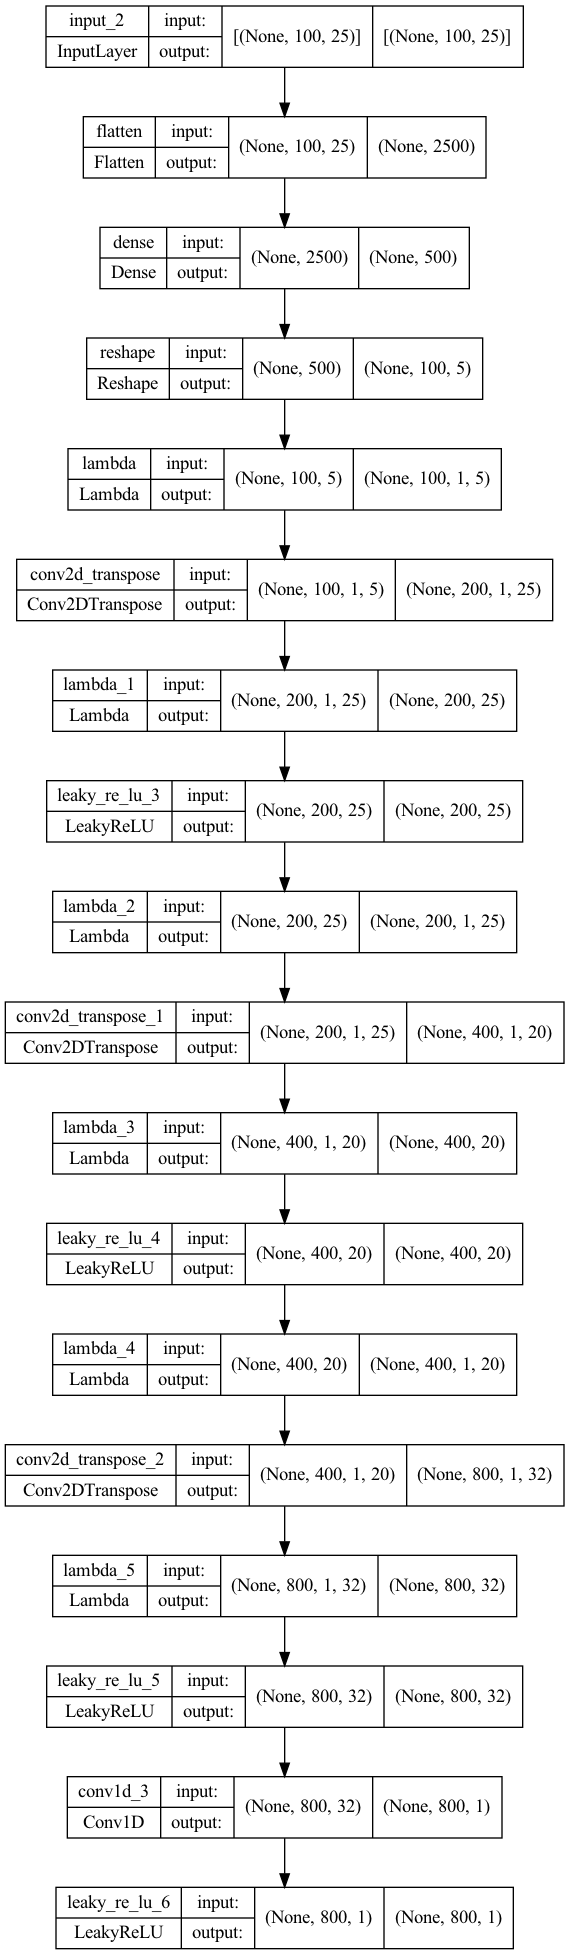

In [ ]:
from keras.utils.vis_utils import plot_model

# encoder.summary()
plot_model(decoder, to_file='decoder.png', show_shapes=True)

## load previously saved models

In [ ]:
from keras.models import load_model

autoencoder = load_model('models/cdae.h5')
encoder = load_model('models/encoder.h5')
decoder = load_model('models/decoder.h5')

encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        (None, 800, 1)            0         
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 800, 32)           352       
_________________________________________________________________
leaky_re_lu_81 (LeakyReLU)   (None, 800, 32)           0         
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 400, 32)           0         
_________________________________________________________________
conv1d_49 (Conv1D)           (None, 400, 20)           5140      
_________________________________________________________________
leaky_re_lu_82 (LeakyReLU)   (None, 400, 20)           0         
_________________________________________________________________
max_pooling1d_38 (MaxPooling (None, 200, 20)           0   

/mapr/houmaprdev/user/ybolisetty/.conda/envs/py377/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


# Train model

In [18]:
# %%capture output

# shortened dataset
# y_train = y_train[0:10000]

# Train the model
EPOCHS = 100
BS = 32

autoencoder.set_weights(fresh_weights)
print(y_test.shape)

H = autoencoder.fit(x_train_noisy, y_train,
                epochs=EPOCHS,
                batch_size=BS,
                shuffle=True,
                validation_data=(x_test_noisy, y_test)
               )

# test against labels
# H = autoencoder.fit(y_train, y_train,
#                 epochs=EPOCHS,
#                 batch_size=BS,
#                 shuffle=True,
#                 validation_data=(y_test, y_test)
#                )

keras.backend.clear_session()

# autoencoder.save('models/cdae.h5')
# encoder.save('models/encoder.h5')
# decoder.save('models/decoder.h5')

(70992, 800, 1)
Epoch 1/100
8874/8874 [==============================] - 58s 7ms/step - loss: 0.0016 - val_loss: 4.7354e-04
Epoch 2/100
8874/8874 [==============================] - 58s 6ms/step - loss: 4.3209e-04 - val_loss: 3.7502e-04
Epoch 3/100
8874/8874 [==============================] - 58s 7ms/step - loss: 3.5064e-04 - val_loss: 3.1609e-04
Epoch 4/100
8874/8874 [==============================] - 58s 7ms/step - loss: 3.1442e-04 - val_loss: 2.9927e-04
Epoch 5/100
8874/8874 [==============================] - 58s 7ms/step - loss: 2.9214e-04 - val_loss: 2.7612e-04
Epoch 6/100
8874/8874 [==============================] - 58s 7ms/step - loss: 2.7776e-04 - val_loss: 2.6529e-04
Epoch 7/100
8874/8874 [==============================] - 58s 7ms/step - loss: 2.6638e-04 - val_loss: 2.6180e-04
Epoch 8/100
8874/8874 [==============================] - 59s 7ms/step - loss: 2.5770e-04 - val_loss: 2.5290e-04
Epoch 9/100
8874/8874 [==============================] - 58s 7ms/step - loss: 2.4946e-04 - v

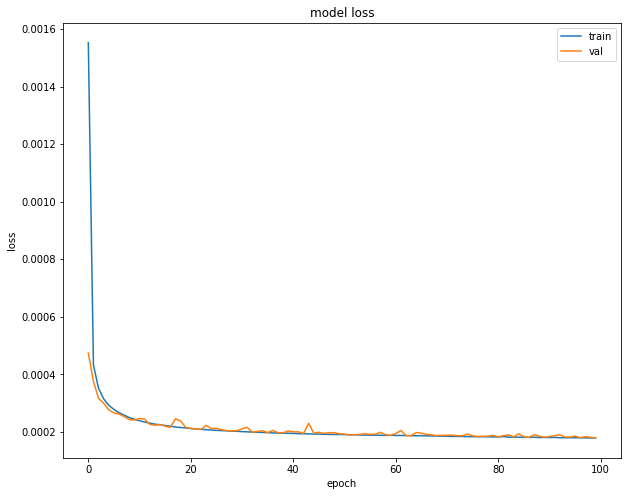

In [22]:
plt.figure(figsize=(10,8))
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
# plt.plot(H.history['af_output_loss'])
# plt.plot(H.history['qa_output_loss'])
plt.title('model loss')
plt.ylabel('loss')
# plt.ylim((0,0.25))
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Evaluate model

In [ ]:
autoencoder.evaluate(x_test_noisy, y_test)

In [23]:
autoencoder.save('/content/drive/MyDrive/Colab Notebooks/cdae.h5')
encoder.save('/content/drive/MyDrive/Colab Notebooks/encoder.h5')
decoder.save('/content/drive/MyDrive/Colab Notebooks/decoder.h5')

### temp training results
v0: loss = .119 -> .099\
v1 (latent representation mb): loss = .117 -> .096\
v2 (fixed modulating-signal bug): loss = .0256 -> .0245\
v3 (conv1dtranspose insted of conv+upsample): .0265 -> .0253\
v4 (latent dense neurons + dec. filter sizes): .0013 -> .0005\
final: .0023 -> .00046




In [ ]:
H.history

{'val_loss': [0.00043858316081517605, 0.00035923481887019723],
 'loss': [0.0013875083448563227, 0.0003819078559323216]}

## transfer learning
save encoder layers and their weights to use in pulse model

In [ ]:
tst = np.array([[1,11],[2,12],[3,33]])
for (a,b) in zip(tst[:,0], tst[:,1]):
    print(a,b)

1 11
2 12
3 33


In [24]:
weights_biases = []
for (layer_idx, layer) in enumerate(encoder.layers):
    if len(layer.get_weights()) != 0:
        print(len(layer.get_weights()))
        weights_biases.append(layer.get_weights())

# weights = weights_biases[0]
# biases = weights_biases[1]
# print(type(weights_biases))
# print(type(weights))
np.save('/content/drive/MyDrive/Colab Notebooks/encode_weights.npy', np.asarray(weights_biases), allow_pickle=True)

2
2
2


### check weights in pre_train model

In [ ]:
first_wb = weights_biases[0]
first_w = first_wb[0]
print(first_w[0:10])

[[[-0.03475725  0.10401297  0.06188152  0.05102815  0.04761314
    0.02798477  0.03814266 -0.03868276 -0.06799009 -0.01816625
    0.02250057  0.02974771 -0.09740667  0.09303927  0.02275043
   -0.03453184  0.07731397  0.01749382 -0.04940867  0.05858403
   -0.03599373  0.02861685 -0.11692235  0.0413218  -0.0297378
    0.00565786 -0.05826396 -0.00165547 -0.06909313  0.03516419
    0.1051574  -0.01442058]]

 [[-0.11009713 -0.00951874 -0.04893675  0.01017679 -0.05849171
   -0.05294116  0.09306709  0.00823803  0.08942754  0.13367978
    0.05014917  0.05493815 -0.00401648 -0.08835915  0.04268415
    0.04936718 -0.07344946  0.04098427  0.0617721   0.06197206
   -0.0894503   0.07910965 -0.0989757   0.09774242 -0.10734862
   -0.06202466  0.08628757 -0.00790445 -0.04686262 -0.09498306
    0.11716253 -0.1123151 ]]

 [[-0.08979873  0.11674719  0.10789365  0.03473988  0.09657058
   -0.08822686  0.05107376 -0.02031678  0.06442901 -0.0350438
    0.09115405 -0.0807636  -0.01692739 -0.04230145  0.013957

## testing model predictions

In [ ]:
import IPython.display
import matplotlib.pyplot as plt

test_input = x_test_noisy[0:200000]
# test_input = x_test_noisy
decoded_output = autoencoder.predict(test_input)
decoded_output=decoded_output.squeeze()
decoded_output.shape

(324, 800)

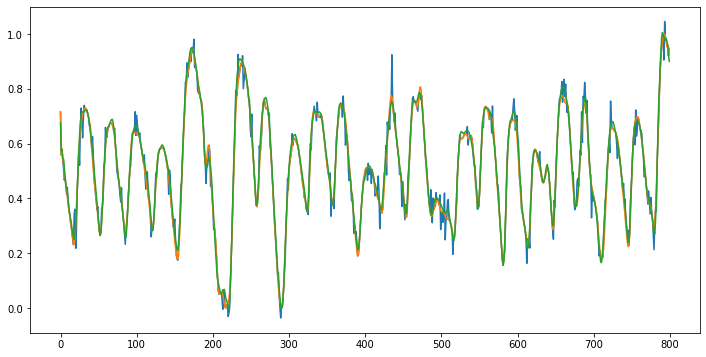

In [ ]:
# good x_train_noisy samples: 150, 450
plt.figure(figsize=(12,6))
plt.plot(x_test_noisy[1240])
plt.plot(y_test[1240])
plt.plot(decoded_output[1240])

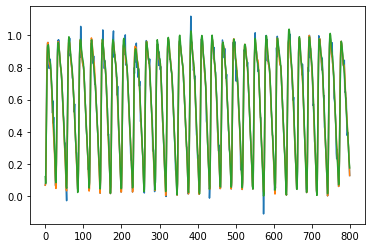

In [ ]:
# good x_train_noisy samples: 150, 450
plt.plot(x_test_noisy[1550])
plt.plot(y_test[1550])
plt.plot(decoded_output[1550])

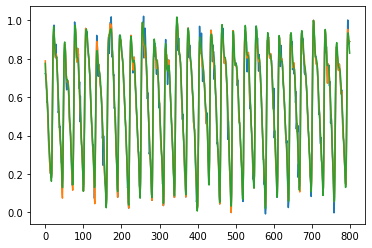

In [ ]:
# good x_train_noisy samples: 150, 450
plt.plot(x_train_noisy[150])
plt.plot(y_train[150])
plt.plot(decoded_output[150])

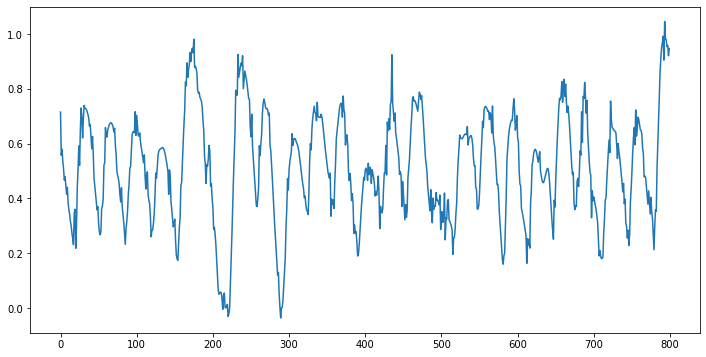

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(x_test_noisy[1240])

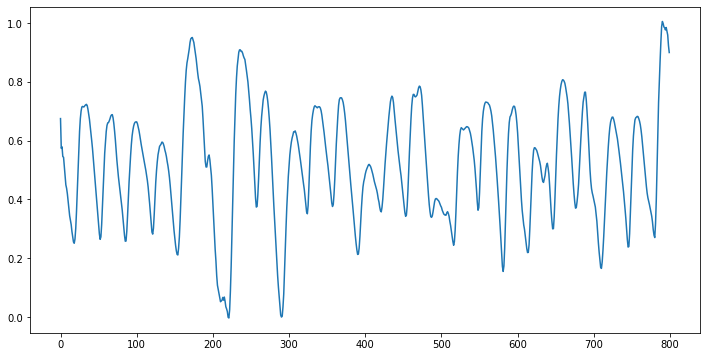

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(decoded_output[1240])

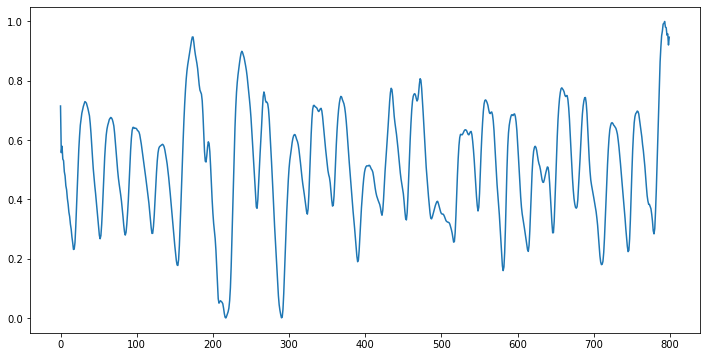

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test[1240])

In [ ]:
results = autoencoder.evaluate(x_test_noisy, y_test)

print(results)


<Figure size 720x720 with 0 Axes>

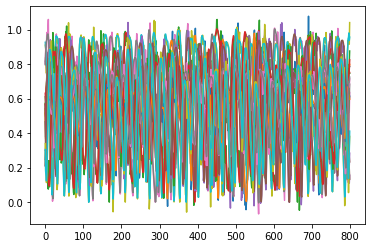

<Figure size 720x720 with 0 Axes>

In [ ]:
outputs = None
for i in range(0,10):
    original = (x_test_noisy[i])
    curr_decode = (decoded_output[i])
    curr_decode = np.expand_dims(curr_decode, axis=1)
    
    output = np.hstack([original, curr_decode])
    
    if outputs is None:
        outputs = output
    else:
        outputs = np.vstack([outputs, output])
        
    plt.plot(output)

plt.figure(figsize=(10,10))
# plt.plot(outputs)

## visualize


In [ ]:
import umap

visualize_mod = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder').get_layer('max_pooling1d_33').output)
print(visualize_mod.output.shape)
stor = visualize_mod.predict(x_test_noisy)

(None, 100, 25)


In [ ]:
stor=stor.squeeze(axis=2)
stor.shape

(110141, 800)

In [ ]:
import umap

embedding = umap.UMAP(n_neighbors=50,
                      min_dist=0.3,
                      metric='correlation').fit_transform(stor[0:5000])
print(embedding.shape)

(5000, 2)


In [ ]:
y_test_af[0:10]

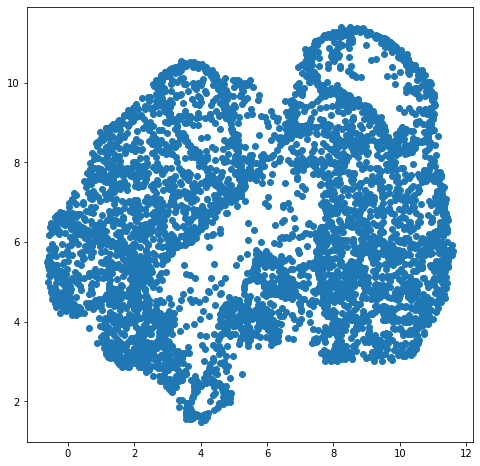

In [ ]:
plt.figure(figsize=(8,8))


plt.scatter(embedding[:,0], embedding[:,1], label=y_test_af[0:5000])

(110141,)


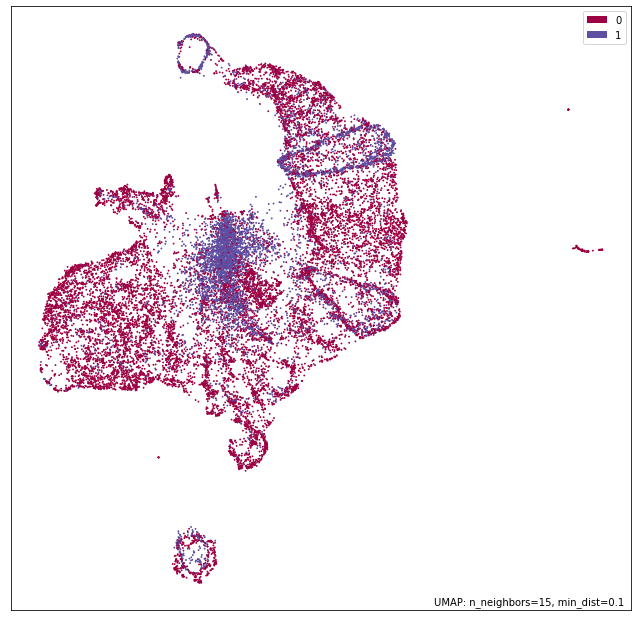

In [ ]:
import umap.plot

mapper = umap.UMAP().fit(stor[0:20000])

# y_test=y_test.squeeze(axis=2)
print(y_test_af.shape)

umap.plot.points(mapper, labels=y_test_af[0:20000])


## Stats
SNR, RMSE to ensure noisy signals are actually denoised. 99%+ of original signal is denoiosed and reproduced in terms of recapturing SNR.

In [ ]:
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

y_test = y_test.squeeze()

output = decoded_output[150]
# ground = y_test[200]
ground = y_test[150]
input_ = x_test_noisy[150]

a = output[40:len(output)-40] 
b = ground[40:len(ground)-40].squeeze() #without squeeze, lin norm goes from 1.69 to 228
c = input_[40:len(input_)-40].squeeze() #without squeeze, lin norm goes from 1.69 to 228

print(np.mean(a!=b))

print('SNR of Pulse CDAE Denoised Signal: ', signaltonoise(a, axis=0))
print('SNR of Ground Truth Clean Signal: ', signaltonoise(b, axis=0))
print('SNR of noisy  Signal: ', signaltonoise(c, axis=0))

mse = np.mean((np.array(c, dtype=np.float32) - np.array(b, dtype=np.float32)) ** 2)
psnr = 20 * np.log10(1 / (np.sqrt(mse)))
print('psnr', psnr)

1.0
SNR of Pulse CDAE Denoised Signal:  2.2903101444244385
SNR of Ground Truth Clean Signal:  2.2842499880498126
SNR of noisy  Signal:  2.2424656652794277
psnr 35.800598225474005


In [ ]:

print(a[0:10])
print(b[0:10])

# np.mean(a[0:10] != b[0:10])
# np.linalg.norm(a[0:10] - b[0:10])
result = 1 - spatial.distance.cosine(a[0:10000], b[0:10000])
result

[0.73815274 0.75480574 0.78216016 0.7628185  0.727831   0.7013201
 0.6540447  0.59313124 0.5670855  0.54397625]
[0.72821677 0.72563562 0.73787173 0.73890387 0.72957901 0.70363994
 0.67026493 0.62320566 0.57283441 0.51032637]


0.9927791476979178

In [ ]:
from scipy import spatial

similarities = []

snrs_noisy = []
snrs_denoised = []
snrs_ground = []
for i in range(0, 55000):
    input_ = x_test_noisy[i]
    output = decoded_output[i]
    ground = y_test[i]
    
    snrs_noisy.append(signaltonoise(input_, axis=0))
    snrs_denoised.append(signaltonoise(output, axis=0))
    snrs_ground.append(signaltonoise(ground, axis=0))

    result = 1 - spatial.distance.cosine(output, ground)
    similarities.append(result)

In [ ]:
np.average(np.asarray(similarities))

0.999429285935989

In [ ]:

dataSetI = [3, 45, 7, 2]
dataSetII = [2, 54, 13, 15]

a = np.asarray([1,2,1,1])
b = np.asarray([0,0,1,0])
np.mean( a != b )

0.75

In [ ]:
a = np.asarray([[0,0,1,0], [1,2,1,1]])
np.sum(a, axis=1)

array([1, 5])